# Integración YOLO + Clasificador para VIDEOS

## Objetivo
Procesar videos en tiempo real usando:
1. **YOLO**: Detectar objetos en cada frame
2. **Nuestro clasificador**: Identificar cada objeto
3. **Tracking**: Seguir objetos a través de los frames

## Casos de uso
- 📹 Procesar video grabado del salón
- 🎥 Cámara en vivo (webcam)
- 📊 Generar estadísticas temporales
- 💾 Guardar video procesado con detecciones

## 1. Imports y configuración

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from collections import defaultdict, Counter
import time
from datetime import timedelta

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Dispositivo: cuda
CUDA disponible: True
GPU: NVIDIA GeForce GTX 1660


## 2. Arquitecturas del modelo (igual que en entrenamiento)

In [6]:
# ============================================================================
# ARQUITECTURA V4 (32×32)
# ============================================================================

class ImprovedAutoencoderV4(nn.Module):
    """Autoencoder V4 para imágenes 32×32."""
    def __init__(self, latent_dim=128):
        super(ImprovedAutoencoderV4, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.to_latent = nn.Sequential(
            nn.Linear(64 * 4 * 4, latent_dim),
            nn.ReLU()
        )
        
        self.from_latent = nn.Sequential(
            nn.Linear(latent_dim, 64 * 4 * 4),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        latent_code = self.to_latent(encoded)
        
        decoded = self.from_latent(latent_code)
        decoded = decoded.view(decoded.size(0), 64, 4, 4)
        reconstructed = self.decoder(decoded)
        
        return reconstructed, latent_code
    
    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        latent_code = self.to_latent(encoded)
        return latent_code


# ============================================================================
# ARQUITECTURA V5 (64×64)
# ============================================================================

class ImprovedAutoencoderV5(nn.Module):
    """Autoencoder V5 para imágenes 64×64."""
    def __init__(self, latent_dim=256):
        super(ImprovedAutoencoderV5, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.to_latent = nn.Sequential(
            nn.Linear(128 * 8 * 8, latent_dim),
            nn.ReLU()
        )
        
        self.from_latent = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        latent_code = self.to_latent(encoded)
        
        decoded = self.from_latent(latent_code)
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        reconstructed = self.decoder(decoded)
        
        return reconstructed, latent_code
    
    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        latent_code = self.to_latent(encoded)
        return latent_code

print("✓ Arquitecturas V4 y V5 definidas")

✓ Arquitecturas V4 y V5 definidas


In [7]:
# ============================================================================
# CLASIFICADOR V4 (para autoencoder V4)
# ============================================================================

class ImprovedClassifierV4(nn.Module):
    """Clasificador V4 para autoencoder V4 (latent_dim=128)."""
    def __init__(self, autoencoder, num_classes, dropout=0.5):
        super(ImprovedClassifierV4, self).__init__()
        self.autoencoder = autoencoder
        self.latent_dim = autoencoder.latent_dim
        
        for param in self.autoencoder.parameters():
            param.requires_grad = False
        
        self.classifier = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        with torch.no_grad():
            latent_code = self.autoencoder.encode(x)
        
        output = self.classifier(latent_code)
        return output


# ============================================================================
# CLASIFICADOR V5 (para autoencoder V5)
# ============================================================================

class ImprovedClassifierV5(nn.Module):
    """Clasificador V5 para autoencoder V5 (latent_dim=256)."""
    def __init__(self, autoencoder, num_classes, dropout=0.5):
        super(ImprovedClassifierV5, self).__init__()
        self.autoencoder = autoencoder
        self.latent_dim = autoencoder.latent_dim
        
        for param in self.autoencoder.parameters():
            param.requires_grad = False
        
        self.classifier = nn.Sequential(
            nn.Linear(self.latent_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        with torch.no_grad():
            latent_code = self.autoencoder.encode(x)
        
        output = self.classifier(latent_code)
        return output

print("✓ Clasificadores V4 y V5 definidos")

✓ Clasificadores V4 y V5 definidos


## 3. Cargar modelos entrenados

In [8]:
# ==================================================================
# CONFIGURACIÓN: Cambia aquí el directorio del modelo
# ==================================================================
MODEL_DIR = 'export_v5'  # <-- Cambiar a 'export_v5' para usar V5
# ==================================================================

# Cargar metadata
with open(f'{MODEL_DIR}/metadata.json', 'r') as f:
    metadata = json.load(f)

classes = metadata['classes']
num_classes = metadata['num_classes']
latent_dim = metadata['architecture']['latent_dim']
img_size = metadata['architecture']['img_size']

# Detectar versión automáticamente
model_version = metadata.get('version', 'v4')

print("="*70)
print("CARGANDO MODELO PARA VIDEO")
print("="*70)
print(f"\nDirectorio: {MODEL_DIR}")
print(f"Versión detectada: {model_version.upper()}")
print(f"Clases: {classes}")
print(f"Latent dim: {latent_dim}")
print(f"Image size: {img_size}x{img_size}")
print("="*70)

CARGANDO MODELO PARA VIDEO

Directorio: export_v5
Versión detectada: V5
Clases: ['cpu', 'mesa', 'mouse', 'nada', 'pantalla', 'silla', 'teclado']
Latent dim: 256
Image size: 64x64


In [9]:
# Crear autoencoder según la versión
if model_version == 'v5' or img_size == 64:
    autoencoder = ImprovedAutoencoderV5(latent_dim=latent_dim)
    print(f"\n Usando arquitectura V5 (64×64)")
else:
    autoencoder = ImprovedAutoencoderV4(latent_dim=latent_dim)
    print(f"\n Usando arquitectura V4 (32×32)")

# Cargar pesos
autoencoder.load_state_dict(
    torch.load(f'{MODEL_DIR}/autoencoder_state.pt', map_location=device)
)
autoencoder.to(device)
autoencoder.eval()

print(f"✓ Autoencoder cargado exitosamente")


 Usando arquitectura V5 (64×64)
✓ Autoencoder cargado exitosamente


In [10]:
# Crear clasificador según la versión
if model_version == 'v5' or img_size == 64:
    classifier = ImprovedClassifierV5(
        autoencoder=autoencoder,
        num_classes=num_classes,
        dropout=0.5
    )
else:
    classifier = ImprovedClassifierV4(
        autoencoder=autoencoder,
        num_classes=num_classes,
        dropout=0.5
    )

# Cargar pesos
classifier.load_state_dict(
    torch.load(f'{MODEL_DIR}/classifier_state.pt', map_location=device)
)
classifier.to(device)
classifier.eval()

print(f"✓ Clasificador cargado exitosamente")
print("\n" + "="*70)

✓ Clasificador cargado exitosamente



In [11]:
# Transformaciones
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print(" Transformaciones listas")

 Transformaciones listas


## 4. Cargar YOLO

In [12]:
from ultralytics import YOLO

# YOLOv8 nano es el más rápido (ideal para video)
yolo_model = YOLO('yolov8n.pt')

print(" YOLO cargado (YOLOv8 Nano)")
print("  Optimizado para velocidad en video")

 YOLO cargado (YOLOv8 Nano)
  Optimizado para velocidad en video


## 5. Función para clasificar recortes

In [13]:
def classify_crop(crop_image):
    """
    Clasifica un recorte de imagen.
    
    Args:
        crop_image: numpy array RGB
    
    Returns:
        (clase, confianza)
    """
    pil_image = Image.fromarray(crop_image)
    img_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = classifier(img_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class = classes[predicted.item()]
    confidence_score = confidence.item()
    
    return predicted_class, confidence_score

print(" Función de clasificación lista")

 Función de clasificación lista


## 6. Clase VideoProcessor - Pipeline completo para video

In [14]:
class VideoProcessor:
    """
    Procesador de video que integra YOLO + Clasificador custom.
    
    Características:
    - Detección frame por frame
    - Clasificación de cada objeto
    - Estadísticas en tiempo real
    - Guardado de video procesado
    """
    
    def __init__(self, yolo_model, classifier, classes, 
                 confidence_threshold=0.25):
        self.yolo = yolo_model
        self.classifier = classifier
        self.classes = classes
        self.confidence_threshold = confidence_threshold
        
        # Colores por clase (BGR)
        self.colors = {
            'cpu': (255, 0, 0),
            'mesa': (0, 255, 0),
            'mouse': (0, 0, 255),
            'nada': (128, 128, 128),
            'pantalla': (255, 255, 0),
            'silla': (255, 0, 255),
            'teclado': (0, 255, 255)
        }
        
        # Estadísticas
        self.reset_stats()
    
    def reset_stats(self):
        """Reinicia estadísticas."""
        self.stats = {
            'total_frames': 0,
            'total_detections': 0,
            'class_counts': Counter(),
            'avg_fps': 0,
            'processing_times': []
        }
    
    def process_frame(self, frame):
        """
        Procesa un solo frame.
        
        Args:
            frame: Frame BGR de OpenCV
        
        Returns:
            (frame_procesado, detecciones)
        """
        start_time = time.time()
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Detectar con YOLO
        results = self.yolo(frame, conf=self.confidence_threshold, verbose=False)
        
        detections = []
        
        # Procesar cada detección
        if len(results[0].boxes) > 0:
            for box in results[0].boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                yolo_conf = float(box.conf[0])
                
                # Recortar objeto
                crop = frame_rgb[y1:y2, x1:x2]
                
                if crop.size == 0:
                    continue
                
                # Clasificar
                custom_class, custom_conf = classify_crop(crop)
                
                detections.append({
                    'bbox': (x1, y1, x2, y2),
                    'class': custom_class,
                    'confidence': custom_conf
                })
                
                # Actualizar estadísticas
                self.stats['class_counts'][custom_class] += 1
        
        # Dibujar detecciones
        processed_frame = self._draw_detections(frame.copy(), detections)
        
        # Actualizar estadísticas de tiempo
        processing_time = time.time() - start_time
        self.stats['processing_times'].append(processing_time)
        self.stats['total_frames'] += 1
        self.stats['total_detections'] += len(detections)
        
        # Calcular FPS
        fps = 1.0 / processing_time if processing_time > 0 else 0
        
        # Dibujar info en frame
        processed_frame = self._draw_info(processed_frame, fps, len(detections))
        
        return processed_frame, detections
    
    def _draw_detections(self, frame, detections):
        """Dibuja bounding boxes y labels."""
        for det in detections:
            x1, y1, x2, y2 = det['bbox']
            class_name = det['class']
            conf = det['confidence']
            
            color = self.colors.get(class_name, (255, 255, 255))
            
            # Bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            
            # Label
            label = f"{class_name} {conf:.2f}"
            (text_w, text_h), _ = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
            )
            
            # Fondo del texto
            cv2.rectangle(frame, (x1, y1 - text_h - 8),
                         (x1 + text_w + 5, y1), color, -1)
            
            # Texto
            cv2.putText(frame, label, (x1 + 2, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        return frame
    
    def _draw_info(self, frame, fps, num_detections):
        """Dibuja información de FPS y detecciones."""
        h, w = frame.shape[:2]
        
        # Fondo semi-transparente para info
        overlay = frame.copy()
        cv2.rectangle(overlay, (10, 10), (300, 100), (0, 0, 0), -1)
        frame = cv2.addWeighted(overlay, 0.6, frame, 0.4, 0)
        
        # Texto
        y_offset = 35
        cv2.putText(frame, f"FPS: {fps:.1f}", (20, y_offset),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        y_offset += 30
        cv2.putText(frame, f"Objetos: {num_detections}", (20, y_offset),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        y_offset += 30
        cv2.putText(frame, f"Frame: {self.stats['total_frames']}", (20, y_offset),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        return frame
    
    def process_video(self, input_path, output_path=None, 
                     show=True, skip_frames=0):
        """
        Procesa un video completo.
        
        Args:
            input_path: Ruta del video de entrada
            output_path: Ruta del video de salida (opcional)
            show: Mostrar video mientras procesa
            skip_frames: Procesar 1 de cada N frames (0 = todos)
        
        Returns:
            Diccionario con estadísticas
        """
        self.reset_stats()
        
        print(f"\n{'='*70}")
        print(f"Procesando video: {input_path}")
        print(f"{'='*70}\n")
        
        # Abrir video
        cap = cv2.VideoCapture(str(input_path))
        
        if not cap.isOpened():
            raise ValueError(f"No se pudo abrir el video: {input_path}")
        
        # Propiedades del video
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        print(f"📹 Propiedades del video:")
        print(f"   Resolución: {width}x{height}")
        print(f"   FPS: {fps}")
        print(f"   Frames totales: {total_frames}")
        print(f"   Duración: {timedelta(seconds=int(total_frames/fps))}\n")
        
        # Configurar writer si se va a guardar
        writer = None
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter(str(output_path), fourcc, fps, 
                                    (width, height))
            print(f"💾 Guardando en: {output_path}\n")
        
        print("🎬 Procesando...")
        print("   Presiona 'q' para detener\n")
        
        frame_count = 0
        
        try:
            while True:
                ret, frame = cap.read()
                
                if not ret:
                    break
                
                frame_count += 1
                
                # Skip frames si se especificó
                if skip_frames > 0 and frame_count % (skip_frames + 1) != 0:
                    continue
                
                # Procesar frame
                processed_frame, detections = self.process_frame(frame)
                
                # Guardar si es necesario
                if writer is not None:
                    writer.write(processed_frame)
                
                # Mostrar si es necesario
                if show:
                    cv2.imshow('YOLO + Clasificador - Video', processed_frame)
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        print("\n⚠️  Detenido por el usuario")
                        break
                
                # Progreso cada 30 frames
                if frame_count % 30 == 0:
                    progress = (frame_count / total_frames) * 100
                    avg_fps = 1.0 / np.mean(self.stats['processing_times'][-30:])
                    print(f"\r   Progreso: {progress:.1f}% | "
                          f"FPS: {avg_fps:.1f} | "
                          f"Detecciones: {self.stats['total_detections']}",
                          end='')
        
        finally:
            cap.release()
            if writer is not None:
                writer.release()
            if show:
                cv2.destroyAllWindows()
        
        # Calcular estadísticas finales
        avg_fps = 1.0 / np.mean(self.stats['processing_times'])
        self.stats['avg_fps'] = avg_fps
        
        print(f"\n\n{'='*70}")
        print("✅ Procesamiento completado")
        print(f"{'='*70}")
        print(f"\n📊 Estadísticas:")
        print(f"   Frames procesados: {self.stats['total_frames']}")
        print(f"   FPS promedio: {avg_fps:.1f}")
        print(f"   Total de detecciones: {self.stats['total_detections']}")
        print(f"\n   Objetos detectados:")
        for class_name, count in self.stats['class_counts'].most_common():
            print(f"      {class_name}: {count}")
        print(f"\n{'='*70}\n")
        
        return self.stats

print(" VideoProcessor definido")

 VideoProcessor definido


## 7. Crear instancia del procesador

In [15]:
# Crear procesador de video
video_processor = VideoProcessor(
    yolo_model=yolo_model,
    classifier=classifier,
    classes=classes,
    confidence_threshold=0.25  # Ajusta según necesites
)

print(" VideoProcessor listo para usar")
print("\n  Funciones disponibles:")
print("    - process_video(): Procesar video grabado")
print("    - process_webcam(): Procesar webcam en vivo (ver siguiente celda)")

 VideoProcessor listo para usar

  Funciones disponibles:
    - process_video(): Procesar video grabado
    - process_webcam(): Procesar webcam en vivo (ver siguiente celda)


## 8. OPCIÓN 1: Procesar video grabado

In [16]:
# Configuración
INPUT_VIDEO = 'objetos_multiple.mp4'  # <-- CAMBIA ESTO
OUTPUT_VIDEO = 'video_procesado.mp4'

# Verificar si existe
if not Path(INPUT_VIDEO).exists():
    print(f"⚠️  No se encontró el video: {INPUT_VIDEO}")
    print("\nOpciones:")
    print("1. Graba un video de tu salón con tu teléfono")
    print("2. Usa la webcam (ver siguiente sección)")
    print("3. Actualiza INPUT_VIDEO con la ruta correcta")
else:
    print(f" Video encontrado: {INPUT_VIDEO}")

 Video encontrado: objetos_multiple.mp4


In [17]:
# Procesar video
if Path(INPUT_VIDEO).exists():
    stats = video_processor.process_video(
        input_path=INPUT_VIDEO,
        output_path=OUTPUT_VIDEO,
        show=True,  # Mostrar mientras procesa
        skip_frames=0  # 0 = procesar todos los frames
                        # 1 = procesar 1 de cada 2
                        # 2 = procesar 1 de cada 3, etc.
    )


Procesando video: objetos_multiple.mp4

📹 Propiedades del video:
   Resolución: 848x474
   FPS: 29
   Frames totales: 563
   Duración: 0:00:19

💾 Guardando en: video_procesado.mp4

🎬 Procesando...
   Presiona 'q' para detener

   Progreso: 95.9% | FPS: 42.8 | Detecciones: 3046

✅ Procesamiento completado

📊 Estadísticas:
   Frames procesados: 563
   FPS promedio: 52.6
   Total de detecciones: 3241

   Objetos detectados:
      pantalla: 959
      mesa: 780
      silla: 616
      teclado: 381
      cpu: 214
      nada: 197
      mouse: 94




## 9. OPCIÓN 2: Procesar webcam en tiempo real

In [ ]:
def process_webcam(processor, camera_id=0, save_path=None):
    """
    Procesa webcam en tiempo real.
    
    Args:
        processor: VideoProcessor instance
        camera_id: ID de la cámara (0 = default)
        save_path: Guardar grabación (opcional)
    """
    processor.reset_stats()
    
    print(f"\n{'='*70}")
    print("PROCESAMIENTO DE WEBCAM EN TIEMPO REAL")
    print(f"{'='*70}\n")
    
    # Abrir webcam
    cap = cv2.VideoCapture(camera_id)
    
    if not cap.isOpened():
        raise ValueError(f"No se pudo abrir la cámara {camera_id}")
    
    # Obtener propiedades
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"📹 Cámara: {camera_id}")
    print(f"   Resolución: {width}x{height}")
    print(f"\n🎥 Presiona 'q' para salir")
    print(f"   Presiona 's' para guardar screenshot\n")
    
    # Configurar writer si se va a grabar
    writer = None
    if save_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(str(save_path), fourcc, 20.0, 
                                (width, height))
        print(f"🔴 Grabando en: {save_path}\n")
    
    screenshot_count = 0
    
    try:
        while True:
            ret, frame = cap.read()
            
            if not ret:
                print("\n⚠️  Error al leer frame")
                break
            
            # Procesar frame
            processed_frame, detections = processor.process_frame(frame)
            
            # Guardar si está grabando
            if writer is not None:
                writer.write(processed_frame)
            
            # Mostrar
            cv2.imshow('Webcam - YOLO + Clasificador', processed_frame)
            
            key = cv2.waitKey(1) & 0xFF
            
            if key == ord('q'):
                print("\n👋 Saliendo...")
                break
            elif key == ord('s'):
                screenshot_count += 1
                screenshot_name = f'screenshot_{screenshot_count:03d}.jpg'
                cv2.imwrite(screenshot_name, processed_frame)
                print(f"📸 Screenshot guardado: {screenshot_name}")
    
    finally:
        cap.release()
        if writer is not None:
            writer.release()
        cv2.destroyAllWindows()
    
    # Estadísticas finales
    if processor.stats['total_frames'] > 0:
        avg_fps = 1.0 / np.mean(processor.stats['processing_times'])
        
        print(f"\n{'='*70}")
        print("📊 Estadísticas de la sesión:")
        print(f"   Frames procesados: {processor.stats['total_frames']}")
        print(f"   FPS promedio: {avg_fps:.1f}")
        print(f"   Total detecciones: {processor.stats['total_detections']}")
        
        if processor.stats['class_counts']:
            print(f"\n   Objetos detectados:")
            for class_name, count in processor.stats['class_counts'].most_common():
                print(f"      {class_name}: {count}")
        
        print(f"{'='*70}\n")

print(" Función de webcam definida")

In [ ]:
# Ejecutar webcam
# Descomentar para usar:

# process_webcam(
#     processor=video_processor,
#     camera_id=0,  # Cámara por defecto
#     save_path='grabacion_webcam.mp4'  # Opcional: grabar
# )

## 10. Análisis temporal (timeline de detecciones)


Analizando timeline del video: objetos_multiple.mp4

Procesados 500 frames...
 Análisis completado



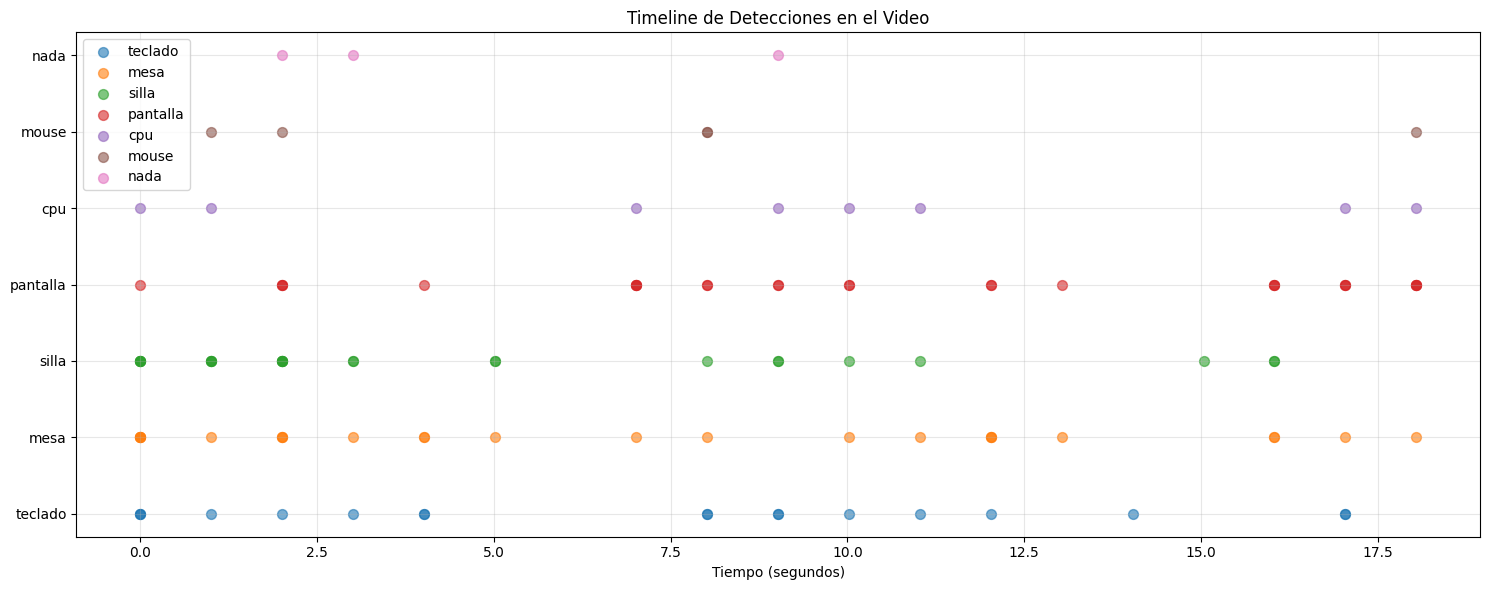

 Función de análisis temporal definida


In [18]:
def analyze_video_timeline(input_path, sample_rate=30):
    """
    Analiza un video y genera un timeline de detecciones.
    
    Args:
        input_path: Ruta del video
        sample_rate: Procesar 1 frame cada N frames
    
    Returns:
        DataFrame con timeline de detecciones
    """
    print(f"\nAnalizando timeline del video: {input_path}\n")
    
    cap = cv2.VideoCapture(str(input_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    timeline = []
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % sample_rate == 0:
            timestamp = frame_count / fps
            _, detections = video_processor.process_frame(frame)
            
            for det in detections:
                timeline.append({
                    'timestamp': timestamp,
                    'frame': frame_count,
                    'class': det['class'],
                    'confidence': det['confidence']
                })
        
        frame_count += 1
        
        if frame_count % 100 == 0:
            print(f"\rProcesados {frame_count} frames...", end='')
    
    cap.release()
    
    print("\n Análisis completado\n")
    
    return timeline

# Ejemplo de uso:
if Path(INPUT_VIDEO).exists():
    timeline = analyze_video_timeline(INPUT_VIDEO, sample_rate=30)
    
    # Visualizar timeline
    class_timeline = defaultdict(list)
    for entry in timeline:
        class_timeline[entry['class']].append(entry['timestamp'])
    
    plt.figure(figsize=(15, 6))
    for i, (class_name, timestamps) in enumerate(class_timeline.items()):
        plt.scatter(timestamps, [i] * len(timestamps), 
                   label=class_name, alpha=0.6, s=50)
    
    plt.yticks(range(len(class_timeline)), list(class_timeline.keys()))
    plt.xlabel('Tiempo (segundos)')
    plt.title('Timeline de Detecciones en el Video')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print(" Función de análisis temporal definida")

## 11. Guardar estadísticas

In [19]:
# Guardar estadísticas del último video procesado
if 'stats' in locals():
    stats_to_save = {
        'total_frames': stats['total_frames'],
        'avg_fps': float(stats['avg_fps']),
        'total_detections': stats['total_detections'],
        'class_counts': dict(stats['class_counts'])
    }
    
    with open('video_stats.json', 'w') as f:
        json.dump(stats_to_save, f, indent=2)
    
    print(" Estadísticas guardadas en: video_stats.json")

 Estadísticas guardadas en: video_stats.json


## 📝 Notas de rendimiento

### FPS esperado según hardware:

| Hardware | YOLOv8n | + Clasificador | Resolución |
|----------|---------|----------------|------------|
| **GPU RTX 3060+** | 60-100 FPS | 40-60 FPS | 1920x1080 |
| **GPU GTX 1060** | 30-50 FPS | 20-30 FPS | 1920x1080 |
| **CPU moderno** | 5-10 FPS | 3-7 FPS | 1920x1080 |

### Optimizaciones si va lento:

1. **Reducir resolución del video**:
   ```python
   # Redimensionar frames antes de procesar
   frame = cv2.resize(frame, (640, 480))
   ```

2. **Skip frames**:
   ```python
   process_video(..., skip_frames=1)  # Procesa 1 de cada 2
   ```

3. **Aumentar umbral de confianza**:
   ```python
   VideoProcessor(..., confidence_threshold=0.5)  # Menos detecciones
   ```

4. **Usar modelo YOLO aún más pequeño**:
   ```python
   # Si existe yolov8n-lite o similar
   ```

### Para tiempo real (webcam):
- Objetivo: ≥15 FPS para experiencia fluida
- Mínimo aceptable: ≥10 FPS
- Si tienes <10 FPS, aplica las optimizaciones arriba